In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7378 - acc: 0.4344
Epoch 00001: val_loss improved from inf to 1.81954, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_3_conv_checkpoint/001-1.8195.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 1.7377 - acc: 0.4344 - val_loss: 1.8195 - val_acc: 0.4410
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1914 - acc: 0.6262
Epoch 00002: val_loss improved from 1.81954 to 1.11336, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_3_conv_checkpoint/002-1.1134.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.1916 - acc: 0.6262 - val_loss: 1.1134 - val_acc: 0.6606
Epoch 3/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.2595 - acc: 0.9266
Epoch 00024: val_loss did not improve from 0.48260
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.2595 - acc: 0.9266 - val_loss: 0.5178 - val_acc: 0.8411
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2440 - acc: 0.9309
Epoch 00025: val_loss improved from 0.48260 to 0.47716, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_3_conv_checkpoint/025-0.4772.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.2441 - acc: 0.9309 - val_loss: 0.4772 - val_acc: 0.8498
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2376 - acc: 0.9333
Epoch 00026: val_loss improved from 0.47716 to 0.46961, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_3_conv_checkpoint/026-0.4696.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.2377 - acc: 0.9333 - v

36800/36805 [============================>.] - ETA: 0s - loss: 0.0897 - acc: 0.9790
Epoch 00052: val_loss did not improve from 0.45525
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0897 - acc: 0.9789 - val_loss: 0.5762 - val_acc: 0.8491
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9799
Epoch 00053: val_loss did not improve from 0.45525
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0854 - acc: 0.9799 - val_loss: 0.4906 - val_acc: 0.8572
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0911 - acc: 0.9780
Epoch 00054: val_loss did not improve from 0.45525
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0912 - acc: 0.9780 - val_loss: 0.5086 - val_acc: 0.8539
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0843 - acc: 0.9796
Epoch 00055: val_loss did not improve from 0.45525
36805/36805 [=====================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9915
Epoch 00082: val_loss did not improve from 0.45525
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0401 - acc: 0.9916 - val_loss: 0.5522 - val_acc: 0.8677
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9930
Epoch 00083: val_loss did not improve from 0.45525
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0364 - acc: 0.9930 - val_loss: 0.5385 - val_acc: 0.8665
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9945
Epoch 00084: val_loss did not improve from 0.45525
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0333 - acc: 0.9944 - val_loss: 0.5687 - val_acc: 0.8605
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9867
Epoch 00085: val_loss did not improve from 0.45525
36805/36805 [========

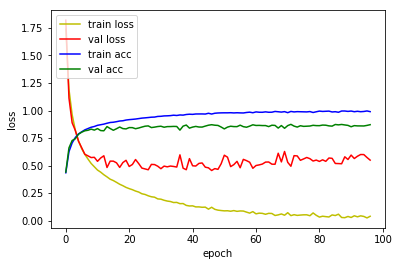

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5681 - acc: 0.8384
Loss: 0.5680644237363821 Accuracy: 0.8384216

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5367 - acc: 0.5124
Epoch 00001: val_loss improved from inf to 1.52242, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_4_conv_checkpoint/001-1.5224.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.5368 - acc: 0.5124 - val_loss: 1.5224 - val_acc: 0.5495
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9219 - acc: 0.7243
Epoch 00002: val_loss improved from 1.52242 to 0.81172, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_4_conv_checkpoint/002-0.8117.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.9219 - acc: 0.7244 - val_loss: 0.8117 - val_acc: 0.7473
Epoch 3/500
36800/36805 [============================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9907
Epoch 00026: val_loss did not improve from 0.33278
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0616 - acc: 0.9907 - val_loss: 0.3828 - val_acc: 0.8898
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9879
Epoch 00027: val_loss did not improve from 0.33278
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0654 - acc: 0.9879 - val_loss: 0.3641 - val_acc: 0.8961
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0667 - acc: 0.9863
Epoch 00028: val_loss did not improve from 0.33278
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0667 - acc: 0.9863 - val_loss: 0.3673 - val_acc: 0.8949
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9932
Epoch 00029: val_loss did not improve from 0.33278
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9988
Epoch 00056: val_loss did not improve from 0.33278
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0118 - acc: 0.9988 - val_loss: 0.3841 - val_acc: 0.9031
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9993
Epoch 00057: val_loss did not improve from 0.33278
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0083 - acc: 0.9993 - val_loss: 0.3957 - val_acc: 0.9038
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9933
Epoch 00058: val_loss did not improve from 0.33278
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0276 - acc: 0.9933 - val_loss: 0.4001 - val_acc: 0.8968
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9970
Epoch 00059: val_loss did not improve from 0.33278
36805/36805 [========

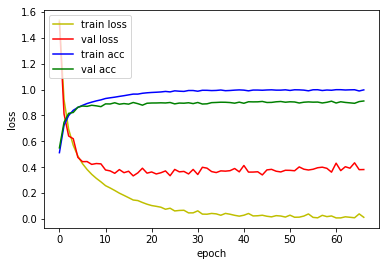

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3745 - acc: 0.8833
Loss: 0.37454007097122455 Accuracy: 0.8832814

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1971 - acc: 0.6341
Epoch 00001: val_loss improved from inf to 1.13694, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_5_conv_checkpoint/001-1.1369.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 1.1972 - acc: 0.6341 - val_loss: 1.1369 - val_acc: 0.6587
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5389 - acc: 0.8476
Epoch 00002: val_loss improved from 1.13694 to 0.48283, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_5_conv_checkpoint/002-0.4828.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.5389 - acc: 0.8476 - val_loss: 0.4828 - val_acc: 0.8640
Epoch 3/500
36800/36805 [===========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9953
Epoch 00027: val_loss did not improve from 0.20381
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0268 - acc: 0.9953 - val_loss: 0.2207 - val_acc: 0.9380
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9981
Epoch 00028: val_loss improved from 0.20381 to 0.20139, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_5_conv_checkpoint/028-0.2014.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0165 - acc: 0.9981 - val_loss: 0.2014 - val_acc: 0.9432
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9992
Epoch 00029: val_loss did not improve from 0.20139
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0090 - acc: 0.9992 - val_loss: 0.2243 - val_acc: 0.9387
Epoch 30/500
36800/36805 [============================>.] - E

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9998
Epoch 00055: val_loss did not improve from 0.18942
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0022 - acc: 0.9998 - val_loss: 0.2116 - val_acc: 0.9464
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9995
Epoch 00056: val_loss did not improve from 0.18942
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0039 - acc: 0.9995 - val_loss: 0.2593 - val_acc: 0.9306
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9950
Epoch 00057: val_loss did not improve from 0.18942
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0197 - acc: 0.9950 - val_loss: 0.1934 - val_acc: 0.9495
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9999
Epoch 00058: val_loss did not improve from 0.18942
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9948
Epoch 00084: val_loss did not improve from 0.18865
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0186 - acc: 0.9948 - val_loss: 0.2222 - val_acc: 0.9439
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9972
Epoch 00085: val_loss did not improve from 0.18865
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0110 - acc: 0.9972 - val_loss: 0.2218 - val_acc: 0.9469
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9998
Epoch 00086: val_loss did not improve from 0.18865
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0025 - acc: 0.9998 - val_loss: 0.2023 - val_acc: 0.9460
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0012 - acc: 1.0000
Epoch 00087: val_loss did not improve from 0.18865
36805/36805 [=====================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9991
Epoch 00114: val_loss did not improve from 0.18865
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0045 - acc: 0.9991 - val_loss: 0.2400 - val_acc: 0.9446
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9997
Epoch 00115: val_loss did not improve from 0.18865
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0021 - acc: 0.9997 - val_loss: 0.2282 - val_acc: 0.9457
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.9999
Epoch 00116: val_loss did not improve from 0.18865
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0014 - acc: 0.9999 - val_loss: 0.2312 - val_acc: 0.9471
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9981
Epoch 00117: val_loss did not improve from 0.18865
36805/36805 [====

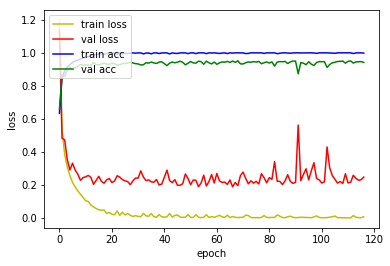

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2572 - acc: 0.9348
Loss: 0.2571553029750521 Accuracy: 0.9347871

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8915 - acc: 0.7333
Epoch 00001: val_loss improved from inf to 0.66023, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_6_conv_checkpoint/001-0.6602.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.8915 - acc: 0.7333 - val_loss: 0.6602 - val_acc: 0.8274
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3452 - acc: 0.9028
Epoch 00002: val_loss improved from 0.66023 to 0.35303, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_6_conv_checkpoint/002-0.3530.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.3453 - acc: 0.9028 - val_loss: 0.3530 - val_acc: 0.8940
Epoch 3/500
36800/36805 [============================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9996
Epoch 00027: val_loss did not improve from 0.14808
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0059 - acc: 0.9996 - val_loss: 0.1651 - val_acc: 0.9546
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9957
Epoch 00028: val_loss did not improve from 0.14808
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0212 - acc: 0.9957 - val_loss: 0.1777 - val_acc: 0.9539
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0056 - acc: 0.9996
Epoch 00029: val_loss did not improve from 0.14808
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0056 - acc: 0.9996 - val_loss: 0.1525 - val_acc: 0.9578
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9989
Epoch 00030: val_loss did not improve from 0.14808
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9982
Epoch 00056: val_loss did not improve from 0.13419
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0076 - acc: 0.9982 - val_loss: 0.1487 - val_acc: 0.9623
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9999
Epoch 00057: val_loss did not improve from 0.13419
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0019 - acc: 0.9998 - val_loss: 0.1353 - val_acc: 0.9634
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9959
Epoch 00058: val_loss did not improve from 0.13419
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0152 - acc: 0.9959 - val_loss: 0.1573 - val_acc: 0.9588
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9998
Epoch 00059: val_loss did not improve from 0.13419
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9999
Epoch 00085: val_loss did not improve from 0.12921
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0011 - acc: 0.9999 - val_loss: 0.1497 - val_acc: 0.9637
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0010 - acc: 0.9999
Epoch 00086: val_loss did not improve from 0.12921
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0010 - acc: 0.9999 - val_loss: 0.1659 - val_acc: 0.9585
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9991
Epoch 00087: val_loss did not improve from 0.12921
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0043 - acc: 0.9991 - val_loss: 0.1564 - val_acc: 0.9658
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9994
Epoch 00088: val_loss did not improve from 0.12921
36805/36805 [=====================

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9994
Epoch 00115: val_loss did not improve from 0.12921
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0026 - acc: 0.9994 - val_loss: 0.2181 - val_acc: 0.9525
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9977
Epoch 00116: val_loss did not improve from 0.12921
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0081 - acc: 0.9977 - val_loss: 0.1488 - val_acc: 0.9655
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9999
Epoch 00117: val_loss did not improve from 0.12921
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0011 - acc: 0.9999 - val_loss: 0.1532 - val_acc: 0.9648

1D_CNN_custom_multi_2_GMP_ch_128_BN_6_conv Model


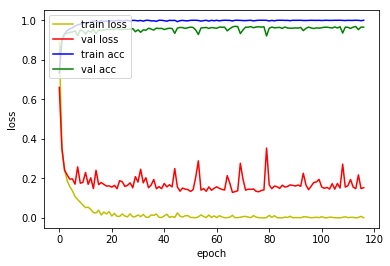

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1607 - acc: 0.9564
Loss: 0.1607014153388678 Accuracy: 0.95638627

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7155 - acc: 0.7833
Epoch 00001: val_loss improved from inf to 0.55079, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_7_conv_checkpoint/001-0.5508.hdf5
36805/36805 [==============================] - 122s 3ms/sample - loss: 0.7154 - acc: 0.7833 - val_loss: 0.5508 - val_acc: 0.8397
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2619 - acc: 0.9224
Epoch 00002: val_loss improved from 0.55079 to 0.21374, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_7_conv_checkpoint/002-0.2137.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.2620 - acc: 0.9223 - val_loss: 0.2137 - val_acc: 0.9380
Epoch 3/500
36800/36805 [===========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9979
Epoch 00027: val_loss did not improve from 0.11307
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0112 - acc: 0.9978 - val_loss: 0.1621 - val_acc: 0.9525
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9958
Epoch 00028: val_loss did not improve from 0.11307
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0162 - acc: 0.9958 - val_loss: 0.1136 - val_acc: 0.9679
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9996
Epoch 00029: val_loss did not improve from 0.11307
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0039 - acc: 0.9996 - val_loss: 0.1177 - val_acc: 0.9662
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9995
Epoch 00030: val_loss did not improve from 0.11307
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9998
Epoch 00057: val_loss did not improve from 0.11307
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0016 - acc: 0.9998 - val_loss: 0.1424 - val_acc: 0.9644
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9996
Epoch 00058: val_loss did not improve from 0.11307
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0024 - acc: 0.9996 - val_loss: 0.1319 - val_acc: 0.9667
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9973
Epoch 00059: val_loss did not improve from 0.11307
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0100 - acc: 0.9973 - val_loss: 0.1215 - val_acc: 0.9690
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9998
Epoch 00060: val_loss did not improve from 0.11307
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9991
Epoch 00086: val_loss did not improve from 0.11203
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0035 - acc: 0.9991 - val_loss: 0.1203 - val_acc: 0.9706
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9995
Epoch 00087: val_loss did not improve from 0.11203
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0021 - acc: 0.9995 - val_loss: 0.1190 - val_acc: 0.9732
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.1649e-04 - acc: 0.9999
Epoch 00088: val_loss did not improve from 0.11203
36805/36805 [==============================] - 111s 3ms/sample - loss: 6.1650e-04 - acc: 0.9999 - val_loss: 0.1198 - val_acc: 0.9706
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0010 - acc: 0.9999
Epoch 00089: val_loss did not improve from 0.11203
36805/36805 [=============

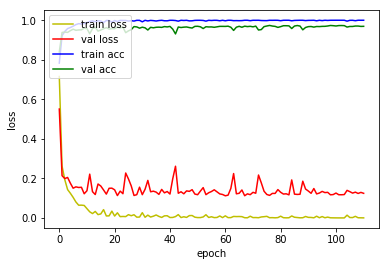

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1444 - acc: 0.9643
Loss: 0.14437985515370888 Accuracy: 0.9642783

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7116 - acc: 0.7799
Epoch 00001: val_loss improved from inf to 0.48537, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_8_conv_checkpoint/001-0.4854.hdf5
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.7115 - acc: 0.7799 - val_loss: 0.4854 - val_acc: 0.8528
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2613 - acc: 0.9184
Epoch 00002: val_loss improved from 0.48537 to 0.23338, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_BN_8_conv_checkpoint/002-0.2334.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.2613 - acc: 0.9184 - val_loss: 0.2334 - val_acc: 0.9245
Epoch 3/500
36800/36805 [===========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9917
Epoch 00027: val_loss did not improve from 0.11658
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0267 - acc: 0.9917 - val_loss: 0.1308 - val_acc: 0.9646
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9934
Epoch 00028: val_loss did not improve from 0.11658
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0228 - acc: 0.9934 - val_loss: 0.1405 - val_acc: 0.9611
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9985
Epoch 00029: val_loss did not improve from 0.11658
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0073 - acc: 0.9985 - val_loss: 0.1516 - val_acc: 0.9588
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9968
Epoch 00030: val_loss did not improve from 0.11658
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9998
Epoch 00056: val_loss did not improve from 0.10899
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0016 - acc: 0.9998 - val_loss: 0.1180 - val_acc: 0.9693
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.9998
Epoch 00057: val_loss did not improve from 0.10899
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1261 - val_acc: 0.9704
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.9990
Epoch 00058: val_loss did not improve from 0.10899
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0044 - acc: 0.9990 - val_loss: 0.2558 - val_acc: 0.9394
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9955
Epoch 00059: val_loss did not improve from 0.10899
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9993
Epoch 00086: val_loss did not improve from 0.10899
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0028 - acc: 0.9993 - val_loss: 0.1340 - val_acc: 0.9681
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9991
Epoch 00087: val_loss did not improve from 0.10899
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0034 - acc: 0.9991 - val_loss: 0.1411 - val_acc: 0.9686
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9989
Epoch 00088: val_loss did not improve from 0.10899
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0038 - acc: 0.9989 - val_loss: 0.1426 - val_acc: 0.9693
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9991
Epoch 00089: val_loss did not improve from 0.10899
36805/36805 [========

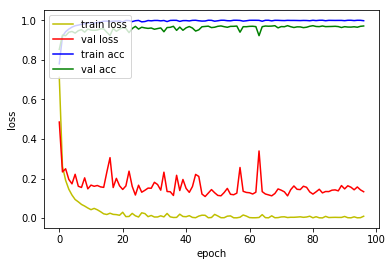

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1451 - acc: 0.9618
Loss: 0.14509350173697572 Accuracy: 0.9617861



In [10]:
base = '1D_CNN_custom_multi_2_GMP_ch_128_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_ch_128_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
___________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3745 - acc: 0.8833
Loss: 0.37454007097122455 Accuracy: 0.8832814

1D_CNN_custom_multi_2_GMP_ch_128_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1607 - acc: 0.9564
Loss: 0.1607014153388678 Accuracy: 0.95638627

1D_CNN_custom_multi_2_GMP_ch_128_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1451 - acc: 0.9618
Loss: 0.14509350173697572 Accuracy: 0.9617861


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GMP_ch_128_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
___________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4360 - acc: 0.8897
Loss: 0.43597502226893897 Accuracy: 0.8897196

1D_CNN_custom_multi_2_GMP_ch_128_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1668 - acc: 0.9583
Loss: 0.16680799333779053 Accuracy: 0.95825547

1D_CNN_custom_multi_2_GMP_ch_128_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activati

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1677 - acc: 0.9599
Loss: 0.1676736310158125 Accuracy: 0.95991695
